# Projet 7 – Traitement automatique d’images avec Deep Learning

Ce projet introduit la vision par ordinateur. Vous développerez un modèle de deep learning pour classer automatiquement des images à partir d'un dataset semi-étiqueté.

🔧 Objectifs :
- Préparation des images
- Construction d’un réseau de neurones convolutionnel

Data:
- Données issue [kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import os

FOLDER_PRED = "seg_pred"
FOLDER_TEST = "seg_test"
FILE_TRAIN = "seg_train"

FILES_PRED = os.listdir(f"../data/{FOLDER_PRED}")
FOLDERS_TEST = os.listdir(f"../data/{FOLDER_TEST}")
FOLDERS_TRAIN = os.listdir(f"../data/{FILE_TRAIN}")

print(f"Found {len(FILES_PRED)} prediction files, {len(FOLDERS_TEST)} test folders, and {len(FOLDERS_TRAIN)} training folders.")

from PIL import Image

COLUMNS = ["Image", "Label"]
DATA_TEST = pd.DataFrame(columns=COLUMNS)
for folder in FOLDERS_TEST:
    folder_path = f"../data/{FOLDER_TEST}/{folder}"
    for file in os.listdir(folder_path):
        if file.endswith(".png") or file.endswith(".jpg"):
            img_path = os.path.join(folder_path, file)
            label = folder  # Assuming label is the folder name
            ligne = pd.Series({"Image": img_path, "Label": label})
            DATA_TEST = pd.concat([DATA_TEST, ligne.to_frame().T], ignore_index=True)
DATA_TEST = DATA_TEST.drop_duplicates().reset_index(drop=True)
DATA_TEST = DATA_TEST.sample(frac=1).reset_index(drop=True)

DATA_TRAIN = pd.DataFrame(columns=COLUMNS)
for folder in FOLDERS_TRAIN:
    folder_path = f"../data/{FILE_TRAIN}/{folder}"
    for file in os.listdir(folder_path):
        if file.endswith(".png") or file.endswith(".jpg"):
            img_path = os.path.join(folder_path, file)
            label = folder  # Assuming label is the folder name
            ligne = pd.Series({"Image": img_path, "Label": label})
            DATA_TRAIN = pd.concat([DATA_TRAIN, ligne.to_frame().T], ignore_index=True)
DATA_TRAIN = DATA_TRAIN.drop_duplicates().reset_index(drop=True)
DATA_TRAIN = DATA_TRAIN.sample(frac=1).reset_index(drop=True)

Found 6873 prediction files, 6 test folders, and 6 training folders.


In [6]:
DATA_TEST.to_csv(f"../data/{FOLDER_TEST}_data.csv", index=False)
DATA_TRAIN.to_csv(f"../data/{FILE_TRAIN}_data.csv", index=False)

In [8]:
DATA_TEST.head()

,Image,Label
0,../data/seg_test/street/22686.jpg,street
1,../data/seg_test/buildings/24215.jpg,buildings
2,../data/seg_test/forest/23490.jpg,forest
3,../data/seg_test/mountain/21276.jpg,mountain
4,../data/seg_test/mountain/23291.jpg,mountain


In [9]:
DATA_TRAIN.head()

,Image,Label
0,../data/seg_train/forest/7854.jpg,forest
1,../data/seg_train/sea/18316.jpg,sea
2,../data/seg_train/buildings/4161.jpg,buildings
3,../data/seg_train/forest/18092.jpg,forest
4,../data/seg_train/glacier/8636.jpg,glacier


In [ ]:
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

LABELS = sorted(DATA_TRAIN["Label"].unique())
LABEL2IDX = {label: idx for idx, label in enumerate(LABELS)}
IDX2LABEL = {idx: label for label, idx in LABEL2IDX.items()}

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["Image"]
        label = self.dataframe.iloc[idx]["Label"]
        image = load_image(img_path)
        label_idx = LABEL2IDX[label]
        return image, label_idx

train_dataset = ImageDataset(DATA_TRAIN)
test_dataset = ImageDataset(DATA_TEST)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(32 * 32 * 32, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(DATA_TRAIN["Label"].unique())).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 0.9473
Epoch [2/10], Loss: 0.6571
Epoch [3/10], Loss: 0.4753
Epoch [4/10], Loss: 0.3278
Epoch [5/10], Loss: 0.2098
Epoch [6/10], Loss: 0.1331
Epoch [7/10], Loss: 0.0753
Epoch [8/10], Loss: 0.0616
Epoch [9/10], Loss: 0.0534
Epoch [10/10], Loss: 0.0436
Test Accuracy: 75.70%


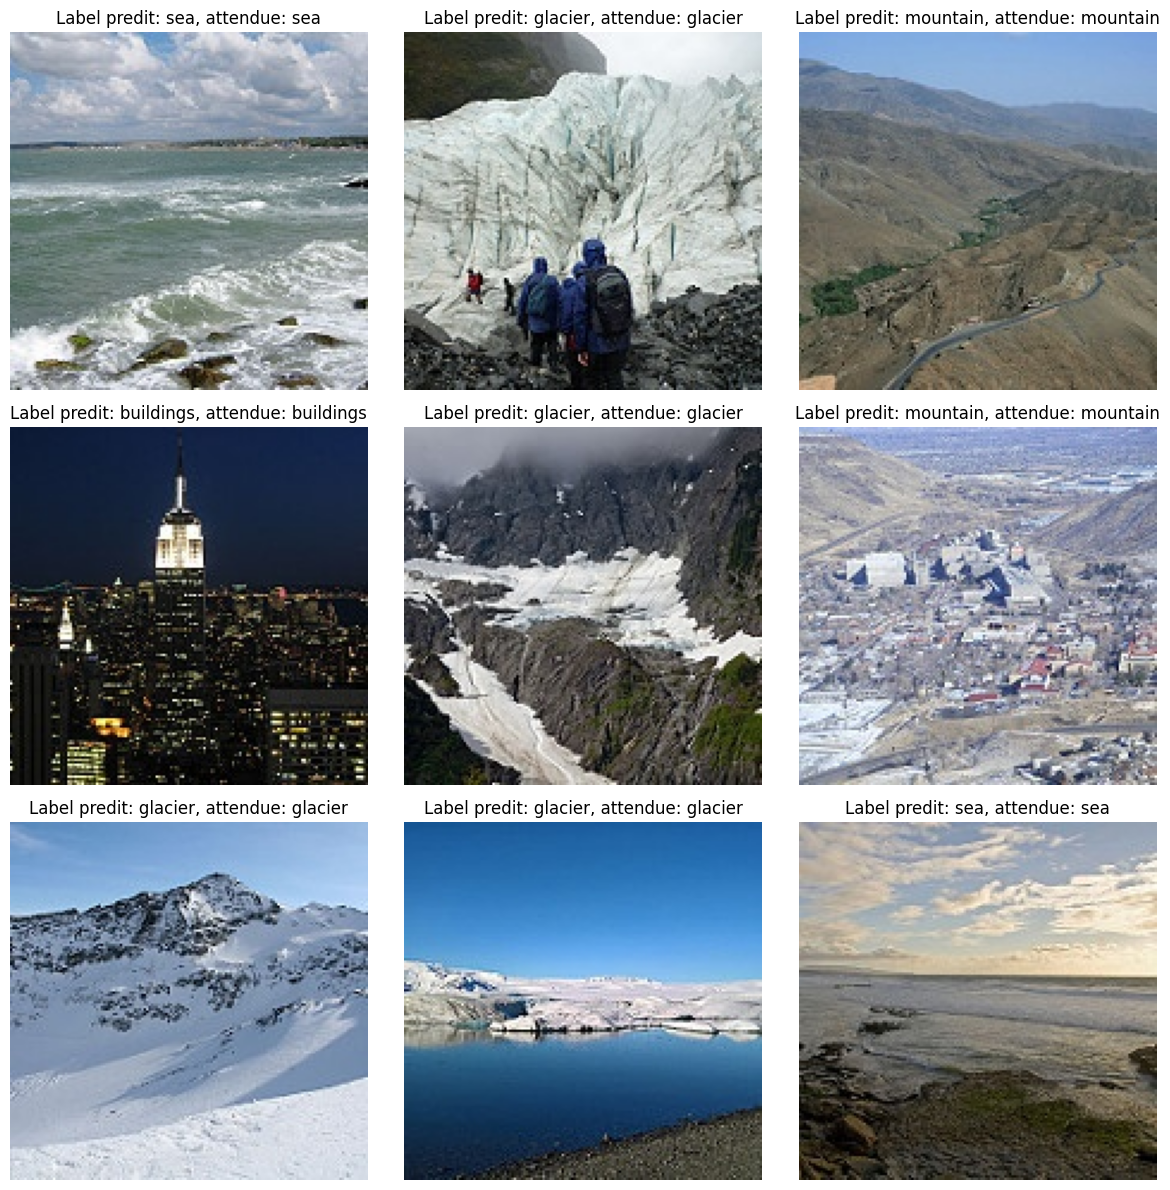

In [16]:
import random

NB_IMAGES = 9
random_indices = random.sample(range(len(DATA_TEST)), NB_IMAGES)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, idx in enumerate(random_indices):
    img_path = DATA_TEST.iloc[idx]["Image"]
    label = DATA_TEST.iloc[idx]["Label"]
    image = Image.open(img_path).convert("RGB")
    axes[i // 3, i % 3].imshow(image)
    axes[i // 3, i % 3].set_title(f"Label predit: {label}, attendue: {IDX2LABEL[LABEL2IDX[label]]}")
    axes[i // 3, i % 3].axis("off")
plt.tight_layout()
plt.show()